# 5.1. Flow Classification Task - Packets

We use **CTU-13 dataset, malware capture 43**. This notebook attempts to classify individual NetFlows (rows in the dataset).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from global_helper import *
from helper import *
from itertools import product

from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

## Load data

In [3]:
%%time

# Read file and preprocess columns (takes ~1.5min)
# Only loads the traffic associated with the provided IP address.
df = load_data("../data/capture20110811.pcap.netflow.labeled")

Wall time: 59 s


In [4]:
df.head(5)

,duration,protocol,flags,tos,packets,bytes,flows,label,src_ip,src_port,dest_ip,dest_port
2011-08-11 10:10:00.003,0.967,UDP,INT,0,2,135,1,Background,89.31.8.11,23929,147.32.84.229,13363
2011-08-11 10:10:00.003,0.967,UDP,INT,0,2,276,1,Background,147.32.84.229,13363,89.31.8.11,23929
2011-08-11 10:10:00.006,0.000,UDP,INT,0,1,62,1,Background,208.88.186.6,34042,147.32.84.229,13363
2011-08-11 10:10:00.008,0.000,UDP,INT,0,1,78,1,Background,92.118.218.77,55246,147.32.84.229,13363
2011-08-11 10:10:00.009,0.000,UDP,INT,0,1,72,1,Background,182.185.139.181,10223,147.32.84.229,13363


## Data analysis
In this section, we analyze the class properties.

Class imbalance:


,label,percentage
LEGITIMATE,225336,80.54
Botnet,54433,19.46


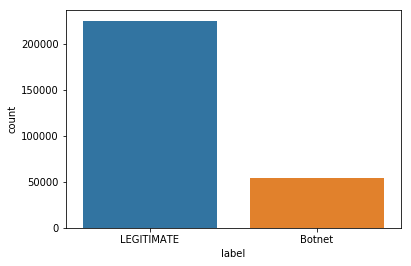

In [5]:
plot_imbalance(df, ["Botnet", "LEGITIMATE"])

## Data preprocessing
In this section, we remove background data, drop irrelevant columns, convert strings categories to numbers and correct the class imbalance.

In [6]:
X_train, X_test, y_train, y_test = preprocess_df_packets(df)

C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Classification
In this section, we experiment with multiple classifiers.

In [8]:
classifiers = {
#     "2-Nearest Neighbors": KNeighborsClassifier(2),
#     "3-Nearest Neighbors": KNeighborsClassifier(3),
#     "5-Nearest Neighbors": KNeighborsClassifier(5),
    # SVM too slow!
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB()
}

### Evaluate classifiers
With and without SMOTE.

Results are also saved in `results_flowclassification_smote_packets.txt`.

In [ ]:
# With SMOTE
for smote_ratio in [0, .25, .5, .75, 1]:

    print("\n\n*****\nSMOTE: %.3f\n*****\n\n" % smote_ratio, flush=True)
    
    if smote_ratio > 0:
        X, y = SMOTE(sampling_strategy=smote_ratio).fit_resample(X_train, y_train)
    else:
        X, y = X_train, y_train
    
    display("Botnet samples: %d / %d" % (np.sum(y), len(y)))
    
    for name, clf in classifiers.items():

        print("\n\nRunning: %s\n" % clf, flush=True)

         # Fit classifier
        clf.fit(X, y)

        # Predict labels for the test set
        y_pred = clf.predict(X_test)

        # Print performance
        print(classification_report(y_test, y_pred, target_names=CLASS_LABEL_LIST), flush=True)
        print_cm(confusion_matrix(y_test, y_pred), CLASS_LABEL_LIST)



*****
SMOTE: 0.000
*****




'Botnet samples: 40839 / 209826'



Running: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

  LEGITIMATE       0.94      1.00      0.97     56349
      Botnet       0.99      0.72      0.83     13594

   micro avg       0.94      0.94      0.94     69943
   macro avg       0.96      0.86      0.90     69943
weighted avg       0.95      0.94      0.94     69943

               LEGITIMATE     Botnet 
    LEGITIMATE      56205        144 
        Botnet       3817       9777 


Running: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity

C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  LEGITIMATE       0.98      0.99      0.99     56349
      Botnet       0.96      0.91      0.94     13594

   micro avg       0.98      0.98      0.98     69943
   macro avg       0.97      0.95      0.96     69943
weighted avg       0.98      0.98      0.98     69943

               LEGITIMATE     Botnet 
    LEGITIMATE      55887        462 
        Botnet       1213      12381 


Running: GaussianNB(priors=None, var_smoothing=1e-09)

              precision    recall  f1-score   support

  LEGITIMATE       0.98      0.85      0.91     56349
      Botnet       0.60      0.92      0.73     13594

   micro avg       0.87      0.87      0.87     69943
   macro avg       0.79      0.89      0.82     69943
weighted avg       0.91      0.87      0.88     69943

               LEGITIMATE     Botnet 
    LEGITIMATE      48067       8282 
        Botnet       1041      12553 


*****
SMOTE: 0.250
*****




'Botnet samples: 42246 / 211233'



Running: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

  LEGITIMATE       0.94      1.00      0.97     56349
      Botnet       0.99      0.72      0.83     13594

   micro avg       0.94      0.94      0.94     69943
   macro avg       0.96      0.86      0.90     69943
weighted avg       0.95      0.94      0.94     69943

               LEGITIMATE     Botnet 
    LEGITIMATE      56205        144 
        Botnet       3817       9777 


Running: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity

'Botnet samples: 84493 / 253480'



Running: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

  LEGITIMATE       0.98      0.97      0.97     56349
      Botnet       0.87      0.91      0.89     13594

   micro avg       0.96      0.96      0.96     69943
   macro avg       0.92      0.94      0.93     69943
weighted avg       0.96      0.96      0.96     69943

               LEGITIMATE     Botnet 
    LEGITIMATE      54469       1880 
        Botnet       1188      12406 


Running: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity

'Botnet samples: 126740 / 295727'



Running: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

              precision    recall  f1-score   support

  LEGITIMATE       0.98      0.97      0.97     56349
      Botnet       0.86      0.91      0.89     13594

   micro avg       0.96      0.96      0.96     69943
   macro avg       0.92      0.94      0.93     69943
weighted avg       0.96      0.96      0.96     69943

               LEGITIMATE     Botnet 
    LEGITIMATE      54409       1940 
        Botnet       1202      12392 


Running: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity